In [10]:
import os
import datetime
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from pathlib import Path

In [2]:
!python -m pip install --upgrade pip
!pip install supervision==0.3.0
!pip install transformers
!pip install pytorch-lightning
!pip install timm
!pip install cython
!pip install pycocotools
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.5/890.5 kB 30.6 MB/s eta 0:00:00


In [84]:
from google.colab import drive
drive.mount('/content/drive')
!rm -rf ./data
!cp -r ./drive/MyDrive/data/ ./data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Utils functions

In [85]:
def find_relaxed_match_in_array(array, element):
    for obj in array:
        if element in obj:
            return obj

def file_have_data(file):
    with open(file, 'r') as read_obj:
        first_char = read_obj.read(1)
    if first_char.isnumeric():
        return True
    else:
        return False

def bbox_transformer(input_coords, img_size, output_type="cv2"):
    """
    Bounding box converter
    ----------
    input_coords : list
    [x, y, width, height], where `x`, `y` center coords, `w` `h` width, height
    of bounind box. All values in percent of original image resolution
    img_size: tuple
    (width, height), width image in px, height image in px.
    output_type : {'cv2', 'matplotlib'}, default: 'cv2'
    If ``'cv2'``, returns coordinates for cv2.rectangle. If
    ``'matplotlib'`` returns coordinates for matplotlib.patches.Rectangle.
    ----------
    """
    x, y, w, h = input_coords
    width, height = img_size
    if output_type == "cv2":
        x1, y1, = [int(x*width - w*width /2), int(y*height  - h*height/2)]
        x2, y2  = [int(x1 + w*width), int(y1 + h*height)]
    elif output_type == "matplotlib":
        x1, y1, x2, y2 = [int(x*width - w*width/2), int(y*height- h*height/2), w*width, h*height]
    else:
        raise TypeError("Incorrect output input {output_type}")
    return x1, y1, x2, y2

def get_img_path(label_path):
    img_path = Path(label_path.replace("labels", "images").replace(".txt", ".JPG"))
    if img_path.is_file():
        return img_path

def get_img_info(img_path, id_number):
    img = Image.open(img_path)
    w, h = img.size
    return {
        "id": id_number,
        "width": w,
        "height": h,
        "file_name": img_path.name,
        "date_captured": str(datetime.datetime.fromtimestamp(os.path.getmtime(img_path))),
    }

def get_label_info(label_file, img_info, id):
    boxes = np.loadtxt(label_file, delimiter=' ')
    if boxes.ndim == 1:
        boxes = boxes.reshape((1, -1))
    labels_info = []
    for box in boxes:
        _, x, y, w, h = box
        x, y, _, _ = bbox_transformer([x, y, w, h], (img_info["width"], img_info["height"]))
        bbox_coord = [x, y, w * img_info["width"], h * img_info["height"]]
        labels_info.append({
            "id": id,
            "image_id": img_info["id"],
            "category_id": 0,
            "area": 0,
            "iscrowd": 0,
            "bbox": bbox_coord,
        })
        id += 1
    return labels_info, id


def save_json(data, file_name):
    with open(file_name, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

def load_json(file_name):
    with open(file_name) as f:
        d = json.load(f)
    return d

def move_file_to_folder(file_path, folder_path, file_name):
    new_file_path = folder_path / Path(str(file_name) + file_path.suffix)
    new_file_path.parent.mkdir(parents=True, exist_ok=True)
    file_path.rename(new_file_path)
    return new_file_path

def draw_img(img_path, boxes):
    img_file = Path(img_path)
    img = Image.open(img_file)
    height, width = img.size
    if boxes.ndim == 1:
        boxes = boxes.reshape((1, -1))
    fig, ax = plt.subplots()
    ax.imshow(img)
    print(f"There is {len(boxes)} bodys")
    for box in boxes:
        x, y, w, h = box
        rect = patches.Rectangle((x,y), w, h, linewidth=0.5, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()


In [71]:
a = Path("fuck/me.txt")
print(a.name)

me.txt


# View images

In [ ]:
DATA_PATH = Path("./data")
IMG_DIR = DATA_PATH / "images"
LABELS_DIR = DATA_PATH / "labels"

IMG_PART = [i for i in IMG_DIR.iterdir()][0]
LABELS_PART= [i for i in LABELS_DIR.iterdir()][0]

images_files = glob.glob(str(IMG_PART)+ "/*")
labels_files = glob.glob(str(LABELS_PART)+ "/*")

There is 4 bodys
0.75709015 0.19592102 0.013434428 0.016286964
0.20278195 0.4704527 0.011594099 0.017667212
0.0054003717 0.9593063 0.0108007435 0.018587334
0.44238746 0.57080346 0.010121824 0.017115086


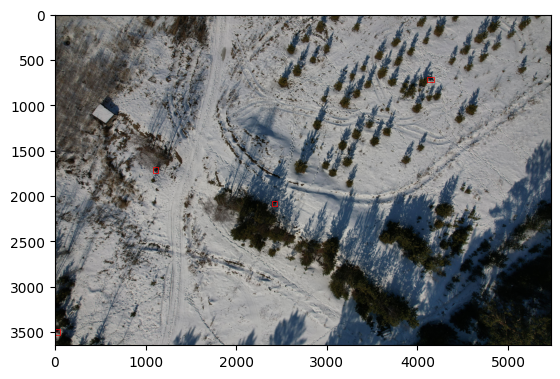

In [ ]:
for img_name in images_files:
    if img_name != "data/images/01/1_000482.JPG":
        continue
    img_file = Path(img_name)
    label_file_matched = find_relaxed_match_in_array(map(str, labels_files), img_file.stem)

    if file_have_data(label_file_matched):
        boxes = np.loadtxt(label_file_matched, delimiter=' ')
        if boxes.ndim == 1:
            boxes = boxes.reshape((1, -1))
        img = Image.open(img_file)
        height, width = img.size
        fig, ax = plt.subplots()
        ax.imshow(img)
        print(f"There is {len(boxes)} bodys")
        for box in boxes:
            _, x, y, w, h = box
            print(x, y, w, h)
            x1, y1, x2, y2 = bbox_transformer([x, y, w, h], (height, width),"matplotlib")
            rect = patches.Rectangle((x1,y1), x2, y2, linewidth=0.5, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        plt.show()


# build COCO dataset

Creating header

In [86]:
info = {"description": "Human Rescue dataset", "year": "2024", "version": "0.1",  "url": "https://disk.yandex.ru/d/bN06_6ncEXTLIw/01_train-s1__DataSet_Human_Rescue", "date_created": "24-10-19 23:07"}
license = {"id": 1, "url": "https://creativecommons.org/licenses/by/4.0", "name": "CC BY 4.0"}
categories = {"id": 0, "name": "body"}


Create annotations list and images list

In [87]:
DATA_PATH = Path("./data")
IMG_DIR = DATA_PATH / "images"
LABELS_DIR = DATA_PATH / "labels"
MOVE_TO = Path("./data/train") # After parsing all imgs move labeled imgs to this folder
annotation_file_name = MOVE_TO / Path("train.json")

IMG_PART = [i for i in IMG_DIR.iterdir()]
LABELS_PART= [i for i in LABELS_DIR.iterdir()]

total_label_files = 0
id_counter = 0
id_label = 0

img_with_labels = []
annotations = []
images = []
for img_part, labels_part in zip(IMG_PART, LABELS_PART):
    images_files = glob.glob(str(img_part)+ "/*")
    labels_files = glob.glob(str(labels_part)+ "/*")
    assert len(images_files) == len(labels_files), f"{len(images_files)} != {len(labels_files)}"
    total_label_files += len(labels_files)
    for label_file in labels_files:
        if not file_have_data(label_file):
            continue
        img_with_labels.append(label_file)
        img_path = get_img_path(label_file)
        if img_path:
            img_path = move_file_to_folder(img_path, MOVE_TO, id_counter)
            img_entry = get_img_info(img_path, id_counter)
            label_entry, id_label = get_label_info(label_file, img_entry, id_label)
            id_counter += 1
        else:
            raise FileExistsError(f"No IMG for label {label_file}")
        annotations += label_entry
        images.append(img_entry)
    print(f"'{labels_part}' has", len(img_with_labels), "/", len(labels_files))
print(f"Labeled {len(img_with_labels)} out of {total_label_files}")

data = {
    "info": info,
    "license": [license],
    "categories": [categories],
    "images": images,
    "annotations": annotations
}
save_json(data, annotation_file_name)


'data/labels/01' has 257 / 341
Labeled 257 out of 341


View parsed image

There is 4 bodys


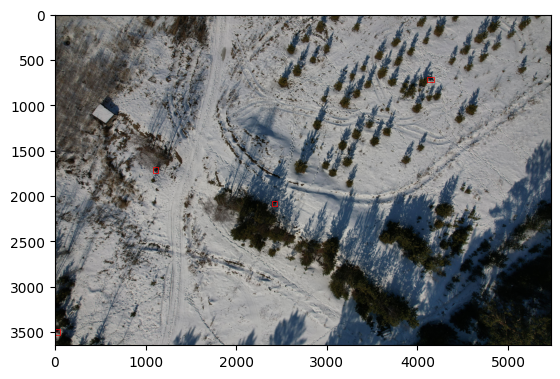

In [88]:
check_id = 171

annotation = load_json(annotation_file_name)

for img in annotation["images"]:
    if img["id"] == check_id:
        target_img = Path(MOVE_TO / Path(img["file_name"]))
bboxes = []
for label in annotation["annotations"]:
    if label["image_id"] == check_id:
        bboxes.append(label["bbox"])

draw_img(target_img, np.array(bboxes))

# DETR


In [49]:
import os
import supervision
import transformers
import torchvision
import pytorch_lightning


print(f"{pytorch_lightning.__version__ =}\n{supervision.__version__=}\n{transformers.__version__=}")

pytorch_lightning.__version__ ='2.4.0'
supervision.__version__='0.3.0'
transformers.__version__='4.44.2'


# COCO data loaders

Only one class = ['body']

In [89]:
dataset = './data'

ANNOTATION_FILE_NAME = "train.json"
TRAIN_DIRECTORY = os.path.join(dataset, "train")
# VAL_DIRECTORY = os.path.join(dataset, "val")
# TEST_DIRECTORY = os.path.join(dataset, "test")
image_processor = transformers.DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(image_directory_path=TRAIN_DIRECTORY, image_processor=image_processor, train=True)

print("Number of training examples:", len(TRAIN_DATASET))



loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 257


Visualize if dataset is loaded properly

Image #125


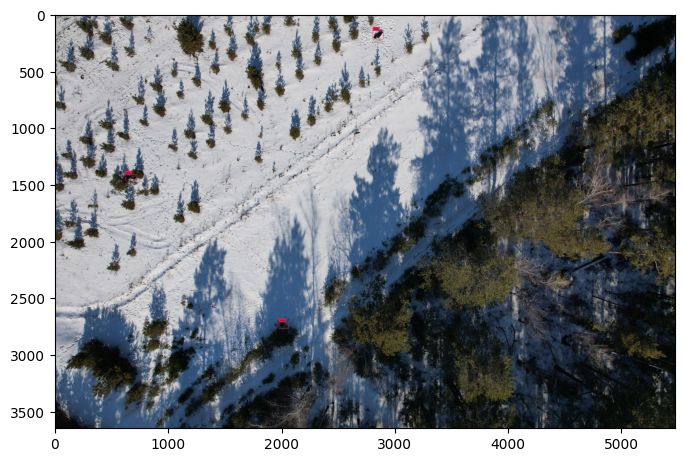

In [90]:
import random
import cv2
import numpy as np
import supervision as sv

image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)
# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
labels = [
    f"{id2label[class_id]}"
    for _, _, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(image, (8, 8))

In [91]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)

# DETR w/ Pytorch⚡

In [92]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path="facebook/detr-resnet-50",
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here:
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

In [93]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [94]:
from pytorch_lightning import Trainer

# settings
MAX_EPOCHS = 200

trainer = Trainer(devices=1, accelerator="gpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

trainer.fit(model)

MisconfigurationException: No supported gpu backend found!